## Parametric Insurance Risk Analysis Interface
This notebook follows an actuarial workflow, proceeding from data setup to policy definition, trigger calibration, and final risk pricing. It uses the robust Percentile Trigger method to ensure triggers are set correctly for highly skewed rainfall data.

### Data and Environment Setup

This block installs dependencies, imports the core analysis functions, and sets up the necessary directories. It also checks for and downloads the 30 years of IMD historical data required for climatology calculations.

In [8]:
# Install necessary libraries (Only needed if running for the first time)
#!pip install imdlib pandas numpy matplotlib

import os
# Import all analysis functions from the core engine module
from parametric_core import *

# Import data handling functions (Note: assuming data_ingestion.py exists or functions are in parametric_core)
from parametric_core import ensure_historical_data_exists, setup_data_directories
import numpy as np
import matplotlib.pyplot as plt

# --- Directory Setup (DO NOT CHANGE) ---
DATA_DIR = 'IMD_Rain_Data'
LPA_DIR = os.path.join(DATA_DIR, 'LPA')
LPA_FILE = os.path.join(LPA_DIR, 'climatology_data.csv')

# 1. Setup directories for data and cache
setup_data_directories(DATA_DIR, LPA_DIR)
# 2. Define Climatology Reference Period (LPA Standard)
LPA_START_YR = 1981
LPA_END_YR = 2010 

# 3. Check and download missing historical data files for the LPA period
ensure_historical_data_exists(DATA_DIR, LPA_START_YR, LPA_END_YR)

print("✅ Setup complete. Data integrity verified.")



✅ Historical data files assumed available or previously downloaded.
✅ Setup complete. Data integrity verified.


### Define Policy and Model Parameters

Define all geographical, contractual, and modeling parameters here. This is the only place you need to change inputs.

In [6]:
# =============================================================================
# DEFINE CONTRACTUAL AND GEOGRAPHICAL PARAMETERS
# =============================================================================

# --- Geographical Target ---
TARGET_LAT = 19.0760  # Example: Mumbai, Maharashtra
TARGET_LON = 72.8777

# --- Contract Parameters ---
# The IMD's "Extremely Heavy Rainfall" threshold (204.5mm) acts as the floor trigger.
BASE_TRIGGER_MM = 204.5 
MAX_PAYOUT_USD = 100000
STUDY_START_YR = 2011  # Use recent history for EAL stress testing
STUDY_END_YR = 2023    

CUMULATIVE_DAYS = 1

# --- Policy Dates (For Live Check Simulation) ---
POLICY_START_DATE = '2025-06-01'
POLICY_END_DATE = '2025-12-30'

print(f"Target Location: {TARGET_LAT}°N, {TARGET_LON}°E")
print(f"Base Trigger for Full Payout: {BASE_TRIGGER_MM} mm/day")
print(f"Max Payout: ${MAX_PAYOUT_USD:,.2f}")

Target Location: 19.076°N, 72.8777°E
Base Trigger for Full Payout: 204.5 mm/day
Max Payout: $100,000.00


###  Calibrate the Extreme Tail Payout Steps

This is the core of the new model. We calculate the $25\text{th}$, $50\text{th}$, and $75\text{th}$ percentile boundaries only among the historical events that were already $\ge 204.5 \text{ mm}$. These define the steps for a $\mathbf{0\%}$ to $\mathbf{100\%}$ graduated payout.

In [10]:
# =============================================================================
# CALIBRATE EXTREME TAIL PAYOUT STEPS (Graduated Severity)
# =============================================================================

# 1. Get the full localized historical data series
lpa_daily, std_dev_daily, rain_series_values = get_climatological_data(
    TARGET_LAT, TARGET_LON, DATA_DIR, STUDY_START_YR, STUDY_END_YR, CUMULATIVE_DAYS)

# 2. Calculate the graduated steps based on the extreme tail distribution
payout_steps = calibrate_extreme_tail(rain_series_values, BASE_TRIGGER_MM)

print("\n--- Extreme Tail Payout Steps (Calculated from Historical Data) ---")
print(f"Total Historical Events >= {BASE_TRIGGER_MM}mm: {payout_steps['count']}")
print(f" BASE TRIGGER (0% Payout Floor): {BASE_TRIGGER_MM:.2f} mm")
print(f" 1. Step 1 (25% Payout): {payout_steps['step_1']:.2f} mm (25th Tail Percentile)")
print(f" 2. Step 2 (50% Payout): {payout_steps['step_2']:.2f} mm (50th Tail Percentile)")
print(f" 3. Step 3 (75% Payout): {payout_steps['step_3']:.2f} mm (75th Tail Percentile)")



--- Extreme Tail Payout Steps (Calculated from Historical Data) ---
Total Historical Events >= 204.5mm: 13
 BASE TRIGGER (0% Payout Floor): 204.50 mm
 1. Step 1 (25% Payout): 232.86 mm (25th Tail Percentile)
 2. Step 2 (50% Payout): 256.01 mm (50th Tail Percentile)
 3. Step 3 (75% Payout): 280.74 mm (75th Tail Percentile)


### Validation and Pricing

This block runs the full historical stress test, using your newly calibrated partial trigger and the fixed full trigger against $30 \text{ years}$ of data. The output provides the Expected Annual Loss (EAL), which forms the basis of the insurance premium.

In [11]:
# Calculates and prints EAL/MAL based on the binary contract
_ = calculate_historical_loss_expectancy(
    TARGET_LAT, TARGET_LON, DATA_DIR, LPA_START_YR, LPA_END_YR,
    BASE_TRIGGER_MM, MAX_PAYOUT_USD, STUDY_START_YR, STUDY_END_YR
)

print("\n--- Financial Stress Test Complete ---")

TypeError: calculate_historical_loss_expectancy() missing 1 required positional argument: 'payout_function'

### Trigger Validation - AEP and Return Period (RP)

This step verifies the Annual Exceedance Probability (AEP) and Return Period (RP) of the $\mathbf{204.5 \text{ mm}}$ Base Trigger and visualizes the binary payout function.


--- Step 5: Trigger Validation (AEP and Return Period) ---
BASE TRIGGER (204.5 mm) AEP/RP Analysis (over 1981-2010 Reference Period):
 - Total Years Analyzed: 30
 - Years Exceeded: 19
 - AEP (Annual Exceedance Probability): 63.33%
 - Return Period (RP): 1.6 Years (e.g., 1-in-1.6 year event)


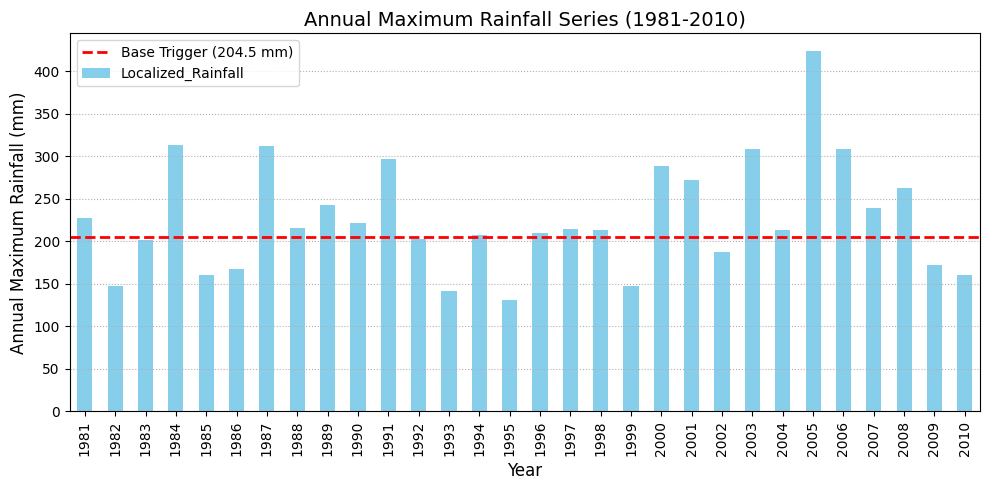

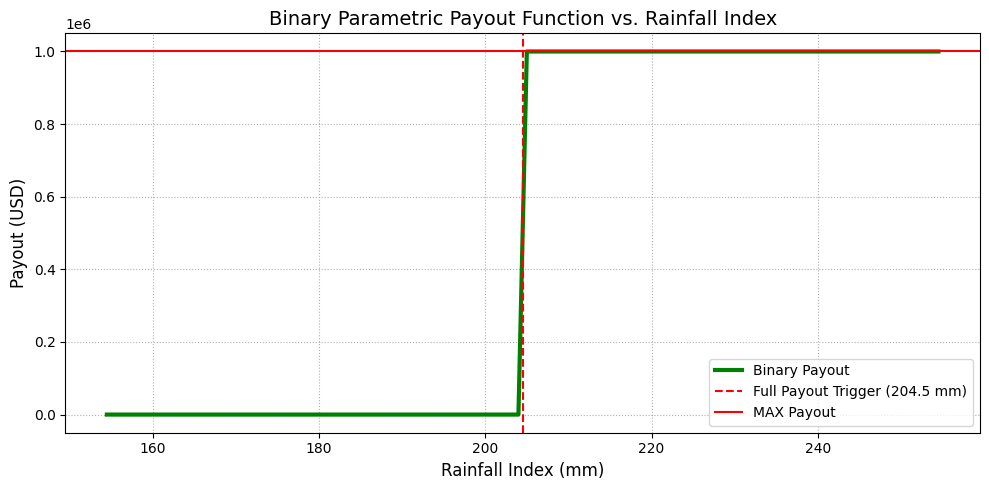

✅ Binary Payout Function Visualized.


In [4]:
from parametric_core import calculate_payout # Import binary payout function

# 1. Analyze AEP and Distribution
aep, rp = analyze_aep_and_distribution(
    TARGET_LAT, TARGET_LON, DATA_DIR, LPA_START_YR, LPA_END_YR, BASE_TRIGGER_MM
)

# 2. Show the binary payout function
# Define a range of rainfall values around the trigger
rainfall_values = np.linspace(BASE_TRIGGER_MM - 50, BASE_TRIGGER_MM + 50, 100)
payouts = [
    calculate_payout(r, BASE_TRIGGER_MM, MAX_PAYOUT_USD) 
    for r in rainfall_values
]

plt.figure(figsize=(10, 5))
plt.plot(rainfall_values, payouts, label='Binary Payout', color='green', linewidth=3)
plt.axvline(BASE_TRIGGER_MM, color='red', linestyle='--', label=f'Full Payout Trigger ({BASE_TRIGGER_MM:.1f} mm)')
plt.axhline(MAX_PAYOUT_USD, color='red', linestyle='-', label='MAX Payout')

plt.title('Binary Parametric Payout Function vs. Rainfall Index', fontsize=14)
plt.xlabel('Rainfall Index (mm)', fontsize=12)
plt.ylabel('Payout (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='dotted')
plt.tight_layout()
plt.show()

print("✅ Binary Payout Function Visualized.")

### Geographical Risk Assessment (Heatmap)

This step provides the spatial context for the risk. The heatmap shows the historical frequency (AEP) of the Partial Payout Trigger being hit across the entire geographical region, allowing you to compare the target location's risk profile against its neighbors.

In [12]:
# Generates the All-India heatmap using the faster MMR Exceedance calculation
create_max_exceedance_heatmap(
    TARGET_LAT, TARGET_LON, DATA_DIR, 2021, 2024, BASE_TRIGGER_MM
)



--- Geographical Risk Assessment: Max Exceedance Heatmap (FAST MMR) ---


KeyboardInterrupt: 

### Final Live Check

This is the final application of the calibrated model, showing what the financial payout would be if the policy were active today, based on the latest available real-time index data.

In [13]:
run_live_parametric_engine(
    TARGET_LAT, TARGET_LON, DATA_DIR, LPA_START_YR, LPA_END_YR, 
    BASE_TRIGGER_MM, MAX_PAYOUT_USD, POLICY_START_DATE, POLICY_END_DATE
)


--- Step 7: Final Live Check ---
Today's Date: 2025-10-18
Simulated Rainfall Index: 152.55 mm

--- Contract Status ---
Base Trigger for Full Payout: 204.5mm
❌ Index not high enough. No Payout.
